# SPT & TESS Coinciding Flare Observation Plot for Upcoming Proposal

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import pandas as pd

from astropy.time import Time
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.io import fits

from scipy.linalg import lstsq
from scipy.optimize import curve_fit

import lightkurve as lk
import tessreduce as tr

import pickle

from datetime import datetime

In [2]:
coinciding_flares_df = pd.read_pickle('spt_tess_candidates.pkl')
coinciding_flares_df

,index,spt_id,mjd,ts,ra,dec,95_flux,95_flux_err,150_flux,150_flux_err,...,phot_bp_mean_mag,phot_rp_mean_mag,parallax,parallax_err,binary,2rxs_id,2rxs_ref,2rxs_flux,sectors,TIC
0,42,SPT-SV J232857.8-680230,59067.63,69.829680,352.241137,-68.041907,33.132387,6.050987,44.396645,6.479653,...,13.298294,10.835975,21.814973,0.016096,True,2RXS J232857.7-680225,Freund,0.0,[28],TIC229807000
1,43,SPT-SV J220610.2-460354,59068.28,65.720511,331.542835,-46.065046,47.818806,8.045753,50.842904,8.377214,...,11.394999,10.820612,2.686802,0.032307,False,NaN,NaN,NaN,[28],TIC279255411
2,46,SPT-SV J025532.4-570257,59110.27,1233.665708,43.885140,-57.049441,162.083004,7.148120,206.963060,7.665012,...,16.325182,13.060138,21.889704,0.021013,False,NaN,NaN,NaN,[29],TIC207138379
3,49,SPT-SV J014432.2-460435,59131.78,48.975169,26.134435,-46.076393,45.598152,8.294850,36.632626,8.695313,...,18.198709,14.208293,25.949235,0.045132,False,NaN,NaN,NaN,[30],TIC401838575


In [41]:
hdul = fits.open("spt3g_flare_lightcurves_flare_single_scan.fits")
hdul.info()

Filename: spt3g_flare_lightcurves_flare_single_scan.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU     42   111R x 12C   [30A, 30A, 30A, 30A, 30A, PD(18), PD(18), PD(18), PD(18), PD(18), PD(18), PD(18)]   


In [42]:
spt_flare_data = hdul[1].data
spt_ids = spt_flare_data.spt_id.astype(str).split('" "')
spt_ids = np.array(list(map(lambda x: x[0], spt_ids)))
gaia_ids = spt_flare_data['gaia_id']

spt_flux_95 = spt_flare_data['95_flux']
spt_flux_err_95 = spt_flare_data['95_err']
spt_flux_150 = spt_flare_data['150_flux']
spt_flux_err_150 = spt_flare_data['150_err']
spt_times = spt_flare_data['time']

In [68]:
SPT_SS = pd.read_csv('flux_calibrated_catalog_scan_start_times_26feb25.csv')
ss_t0_str = SPT_SS[SPT_SS['DR3_source_id']==4909009394396454144]['scan_start_time_mjd'].values[0]
print(type(ss_t0_str))
# dt = datetime.strptime(ss_t0[:-3], '%d-%b-%Y:%H:%M:%S.%f')
# ss_t0 = Time(dt).mjd
# ss_t0

<class 'numpy.float64'>


TIC229807000
SPOC
exptime: 20.000071625690907
TIC279255411
QLP
exptime: 600.0058533230913
TIC207138379
SPOC
exptime: 120.00262312794803
TIC401838575
SPOC
exptime: 600.0011807394912


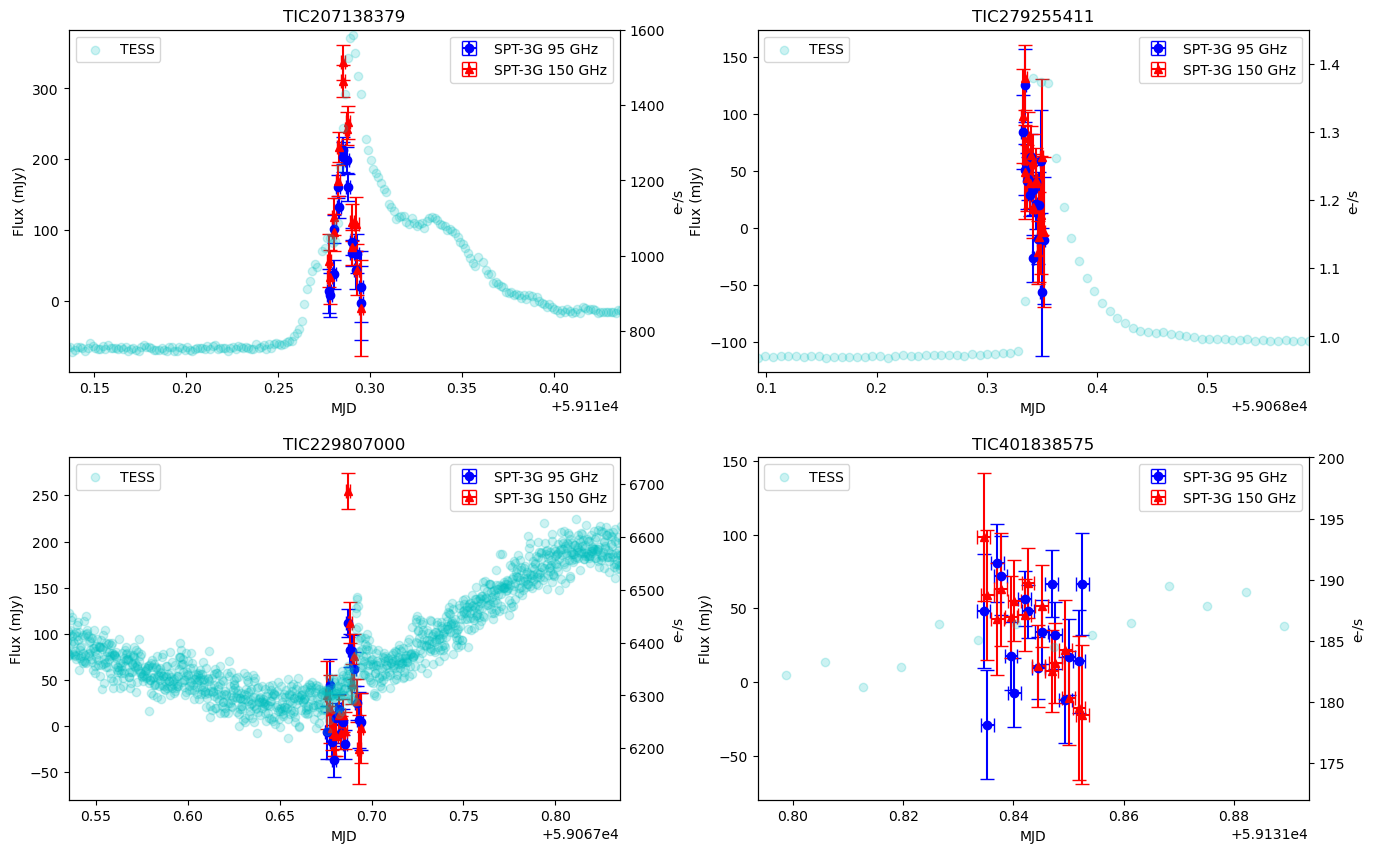

In [94]:
fig = plt.figure(figsize= (16,10))
gs = gridspec.GridSpec(2, 2, figure=fig, wspace=0.25, hspace=0.25)

x_int = { # manually picked to remove impact of other transients within a few days or wierd TESS data processing behavior between observations
    'TIC229807000': 0.15,
    'TIC279255411': 0.25,
    'TIC207138379': 0.15,
    'TIC401838575': 0.05,
}

y_int_TESS = {
    # manually picked to remove impact of other transients within a few days or wierd TESS data processing behavior between observations
    'TIC229807000': 6750,
    'TIC279255411': 1.45,
    'TIC207138379': 1600,
    'TIC401838575': 200,
}

for i, flare in coinciding_flares_df.iterrows(): 
    spt_id = flare['spt_id']
    TIC = flare['TIC']
    print(TIC)
    gaia = flare['dr3_source_id']
    scale_width = scale_int[TIC]
    if i == 0: ax1 = fig.add_subplot(gs[1, 0])
    elif i == 1: ax1 = fig.add_subplot(gs[0, 1])
    elif i == 2: ax1 = fig.add_subplot(gs[0, 0])
    elif i == 3: ax1 = fig.add_subplot(gs[1, 1])
    ax2 = ax1.twinx()

    '''
    SPT quiescent signal is around 0
    '''
    ss_t0 = SPT_SS[SPT_SS['DR3_source_id']== gaia]['scan_start_time_mjd'].values[0]

    ss_times_str = SPT_SS[SPT_SS['DR3_source_id']== gaia]['ss_times'].values[0]
    ss_times_str_dict = eval(ss_times_str.replace('array', 'np.array'))
    ss_times_90 = ss_times_str_dict['90GHz'] / (60*24) + ss_t0
    ss_times_150 = ss_times_str_dict['150GHz'] / (60*24) + ss_t0

    ss_flux_str = SPT_SS[SPT_SS['DR3_source_id']== gaia]['ss_flux'].values[0]
    ss_flux_str_dict = eval(ss_flux_str.replace('array', 'np.array'))
    ss_flux_90 = ss_flux_str_dict['90GHz']
    ss_flux_150 = ss_flux_str_dict['150GHz']

    ss_flux_err_str = SPT_SS[SPT_SS['DR3_source_id']== gaia]['ss_flux_err'].values[0]
    ss_flux_err_str_dict = eval(ss_flux_err_str.replace('array', 'np.array'))
    ss_flux_err_90 = ss_flux_err_str_dict['90GHz']
    ss_flux_err_150 = ss_flux_err_str_dict['150GHz']

    ax1.errorbar(ss_times_90, ss_flux_90, yerr= np.abs(ss_flux_err_90), xerr= 100/(24*3600), fmt='bo', capsize=5, label= 'SPT-3G 95 GHz') #flux error currently hardcoded in as 32 mJy
    ax1.errorbar(ss_times_150, ss_flux_150, yerr= np.abs(ss_flux_err_150), xerr= 100/(24*3600), fmt='r^', capsize=5, label= 'SPT-3G 150 GHz') #flux error currently hardcoded in as 32 mJy

    # def rel_flux(array):
    #     return array / np.nanmax(array)
    # lc_idx = np.where(spt_ids == spt_id)[0][0]
    # print('SPT Flares Dataframe Index:',lc_idx)
    # ax1.errorbar(spt_times[lc_idx], rel_flux(spt_flux_95[lc_idx]), yerr= 32 / np.nanmax(spt_flux_95[lc_idx]) * np.ones_like(np.abs(spt_flux_err_95[lc_idx])), xerr= 100/(24*3600), fmt='bo', capsize=5, label= 'SPT-3G 95 GHz') #flux error currently hardcoded in as 32 mJy
    # ax1.errorbar(spt_times[lc_idx], rel_flux(spt_flux_150[lc_idx]), yerr= 32  / np.nanmax(spt_flux_150[lc_idx]) * np.ones_like(np.abs(spt_flux_err_150[lc_idx])), xerr= 100/(24*3600), fmt='r^', capsize=5, label= 'SPT-3G 150 GHz') #flux error currently hardcoded in as 32 mJy

    target_data = coinciding_flares_df[coinciding_flares_df['TIC'] == TIC]
    obj = lk.search_lightcurve(TIC, mission= 'TESS', sector= target_data["sectors"].iloc[0][0], exptime= 'fast')
    if len(obj) == 0: obj = lk.search_lightcurve(TIC, mission= 'TESS', sector= target_data["sectors"].iloc[0][0], exptime= 'short')
    if len(obj) == 0: obj = lk.search_lightcurve(TIC, mission= 'TESS', sector= target_data["sectors"].iloc[0][0])
    flare_obs = obj[0].download()
    print(flare_obs.author)
    qual = flare_obs.quality.value
    time = np.array(flare_obs.time.value)
    time = time[qual ==0]
    print("exptime:", (time[1] - time[0])*24*3600)
    sap_flux = np.array(flare_obs.sap_flux.value)
    sap_flux = sap_flux[qual ==0]
    time += 2457000.0 - 2400000.5

    '''
    Following Guns et al. 2021 TESS flux is mean subtracted and then scaled to the max within some interval (see scale_int above)
    Guns et al. 2021 uses 2 weeks, but these flares have other transients (flares?) or tess processing 'artifacts' within that duration
    '''
    flare_time = ss_t0 + np.nanmean(ss_times_str_dict['150GHz'] / (24*60))
    # print('SPT Flare Time:',flare_time)
    # flare_region = (time > (flare_time - scale_width)) & (time < (flare_time + scale_width))

    # def normed_2week(array):
    #     mu = np.nanmean(array[flare_region])
    #     high = np.nanmax(array[flare_region])
    #     low = np.nanmin(array[flare_region])
    #     return (array - mu) / (high - mu)

    ax2.scatter(time, sap_flux, c= 'c', alpha= 0.2, label= 'TESS')
    
    ax1.set_ylabel('Flux (mJy)')
    ax2.set_ylabel('e-/s')
    ax1.set_xlabel('MJD')


    ax1.set_xlim(flare_time - scale_width, flare_time + scale_width)
    ax2.set_ylim(None,y_int_TESS[TIC])
    # ax1.set_xlim(flare_time - 4, flare_time + 4) # Longer Time Trend View

    ax1.legend()
    ax2.legend(loc= 'upper left')
    ax1.set_title(TIC)

In [ ]:
0.005 * 24 * 60

In [ ]:
100/24/3600